In [1]:
#!pip install scikeras

In [2]:
#import pandas as pd
#import numpy as np
#import tensorflow as tf
#from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn import metrics
#from imblearn.over_sampling import ADASYN
#from google.colab import drive
#drive.mount('/content/drive/')
#import sys
#sys.path.append('/content/drive/MyDrive')
#from scikeras.wrappers import KerasClassifier
#
#from binary_load import binary_load_dataset
#
#from tensorflow.keras.models import Sequential
#from tensorflow import keras
#from tensorflow.keras import layers as Layer
#from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

In [3]:
import sys
sys.path.append('../')  # 상위 폴더(main_folder)의 경로를 추가

from binary_load import binary_load_dataset

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from imblearn.over_sampling import ADASYN
from scikeras.wrappers import KerasClassifier

from binary_load import binary_load_dataset

from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers as Layer
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

from tensorflow.keras.regularizers import L1L2
from timeit import default_timer as timer
import json

In [5]:
csv_loca = "../../../../data/Star.csv"
TEST_SIZE = 0.2
VAL_SIZE = 0.2
RANDOM_STATE = 42


In [6]:

class TimingCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        print("Starting training")
        self.starttime = timer()

    def on_train_end(self, logs=None):
        print("End of training, took {} seconds".format(timer()-self.starttime))

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
          print("Epoch is {} and {} seconds passed".format(epoch, timer()-self.starttime))

In [7]:

def modelling(nodes1 = 8, nodes2= 6, nodes3 = 4, drop_rate= 0.2, activation= 'relu'):
  # 모델 만들기
  # 뉴런의 개수는 input과 output 사이의 숫자를 넣으라고 한다. --> 사용, 왜냐하면 시간이 적게 걸려서
  # 뉴런의 개수는 input의 2/3 정도 넣라고 한다.
  # 뉴런의 개수는 input의 두배보다는 적게 넣라고 한다.
  regularizer = L1L2(l1=0.001, l2=0.001)

  model = Sequential([Layer.Dense(12, input_shape=(8,))])
  model.add(Layer.Dense(nodes1, activation = activation, kernel_regularizer=regularizer))
  model.add(Layer.BatchNormalization())
  model.add(Layer.Dropout(drop_rate))

  model.add(Layer.Dense(nodes2, activation = activation, kernel_regularizer=regularizer))
  model.add(Layer.BatchNormalization())
  model.add(Layer.Dropout(drop_rate))

  model.add(Layer.Dense(nodes3, activation = activation, kernel_regularizer=regularizer))
  model.add(Layer.BatchNormalization())
  model.add(Layer.Dropout(drop_rate))

  model.add(Layer.Dense(1, activation = 'sigmoid'))

  # metrics에는 1이 나오는 recall 이랑 acc만 중요하다.
  metrics = [
      Recall(name = 'recall'),
      Precision(name = 'precision'),
      BinaryAccuracy(name = 'binary accuracy') # Accuracy를 사용 안 하는 이유는 Accuracy가 이상하세 나왔기 때문.
  ]

  model.compile(optimizer = 'adam',
                loss='binary_crossentropy',
                metrics = metrics)

  return model

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test, X_train_ad, X_val_ad, X_test_ad, y_train_ad, y_val_ad, y_test_ad  = binary_load_dataset(csv_loca, TEST_SIZE, VAL_SIZE, RANDOM_STATE)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((11454, 8), (11454,), (2864, 8), (2864,), (3580, 8), (3580,))

In [9]:
X_train_ad.shape, y_train_ad.shape, X_val_ad.shape, y_val_ad.shape, X_test_ad.shape, y_test_ad.shape

((20711, 8), (20711,), (5178, 8), (5178,), (6473, 8), (6473,))

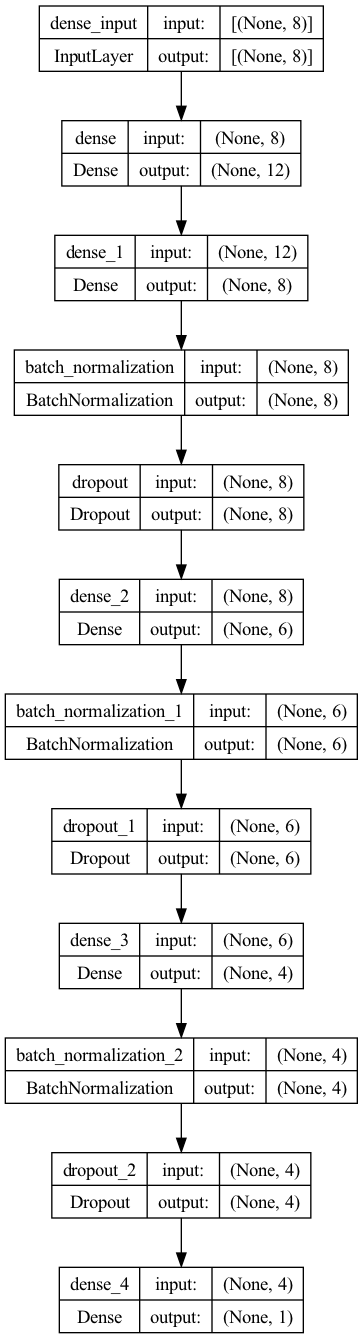

In [10]:
model = modelling()
keras.utils.plot_model(model, show_shapes=True)

In [11]:
model.save('model_layers.h5')

/Users/leetaeryeong/anaconda3/envs/tp1/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:

check_path = 'model_weight.h5'

callback = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50),
    tf.keras.callbacks.ModelCheckpoint(filepath=check_path, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=200, min_lr=0.001),
    TimingCallback()
]

In [13]:
history = model.fit(X_train, y_train, batch_size= 1024, epochs= 1000,  validation_data=(X_val, y_val), callbacks=callback,verbose = 0)

Starting training
Epoch is 0 and 0.7173919999040663 seconds passed
Epoch is 10 and 1.028111832914874 seconds passed
Epoch is 20 and 1.3274531248025596 seconds passed
Epoch is 30 and 1.6284726657904685 seconds passed
Epoch is 40 and 1.9231872498057783 seconds passed
Epoch is 50 and 2.216062332969159 seconds passed
Epoch is 60 and 2.5005579160060734 seconds passed
Epoch is 70 and 2.781347499927506 seconds passed
Epoch is 80 and 3.0692994999699295 seconds passed
Epoch is 90 and 3.351310499943793 seconds passed
Epoch is 100 and 3.6338240408804268 seconds passed
Epoch is 110 and 3.901373665779829 seconds passed
Epoch is 120 and 4.162038582842797 seconds passed
Epoch is 130 and 4.416245708009228 seconds passed
Epoch is 140 and 4.667365249944851 seconds passed
Epoch is 150 and 4.926710875006393 seconds passed
Epoch is 160 and 5.179973999969661 seconds passed
Epoch is 170 and 5.438954124925658 seconds passed
Epoch is 180 and 5.697642415994778 seconds passed
Epoch is 190 and 5.955774375004694 s

In [22]:
model.save('model_layers.h5')

/Users/leetaeryeong/anaconda3/envs/tp1/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:

#model.load_weights(check_path)
results = model.evaluate(X_test, y_test)

112/112 [==============================] - 0s 426us/step - loss: 0.0728 - recall: 0.8476 - precision: 0.9298 - binary accuracy: 0.9802


In [24]:
model.load_weights(check_path)
results = model.evaluate(X_test, y_test)

112/112 [==============================] - 0s 472us/step - loss: 0.0734 - recall: 0.8720 - precision: 0.9108 - binary accuracy: 0.9804


In [16]:

y_test_pred = model.predict(X_test)

y_test_pred = (y_test_pred > 0.35).astype(np.float32)

112/112 [==============================] - 0s 356us/step


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

cm = pd.DataFrame(cm)
cm.columns = ['Predicted 0', 'Predicted 1']
cm.rename(index={0: "True 0", 1: "True 1"}, inplace = True)
cm
     

,Predicted 0,Predicted 1
True 0,3219,33
True 1,38,290


In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3252
           1       0.90      0.88      0.89       328

    accuracy                           0.98      3580
   macro avg       0.94      0.94      0.94      3580
weighted avg       0.98      0.98      0.98      3580



In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist = hist.set_index('epoch')
hist.to_json('model1.json')

with open('model1.json') as json_file:
    json_file = json.loads(json_file.read())
model1_hist = pd.DataFrame(json_file)
model1_hist

,loss,recall,precision,binary accuracy,val_loss,val_recall,val_precision,val_binary accuracy,lr
0,0.870814,0.481411,0.075306,0.411123,0.772670,0.083969,0.015225,0.419344,0.001
1,0.801869,0.610105,0.104661,0.486293,0.764249,0.034351,0.012535,0.664106,0.001
2,0.756535,0.684461,0.121612,0.518334,0.751986,0.015267,0.017937,0.833450,0.001
3,0.716893,0.694948,0.134900,0.563908,0.734161,0.011450,0.176471,0.904679,0.001
4,0.687532,0.755958,0.158632,0.610442,0.715526,0.419847,1.000000,0.946927,0.001
...,...,...,...,...,...,...,...,...,...
325,0.088179,0.827455,0.921444,0.977737,0.082164,0.862595,0.914980,0.980098,0.001
326,0.087133,0.835081,0.922105,0.978435,0.081295,0.839695,0.916667,0.978352,0.001
327,0.085429,0.826501,0.931257,0.978523,0.083781,0.809160,0.917749,0.975908,0.001
328,0.088243,0.826501,0.930257,0.978435,0.081693,0.824427,0.919149,0.977304,0.001


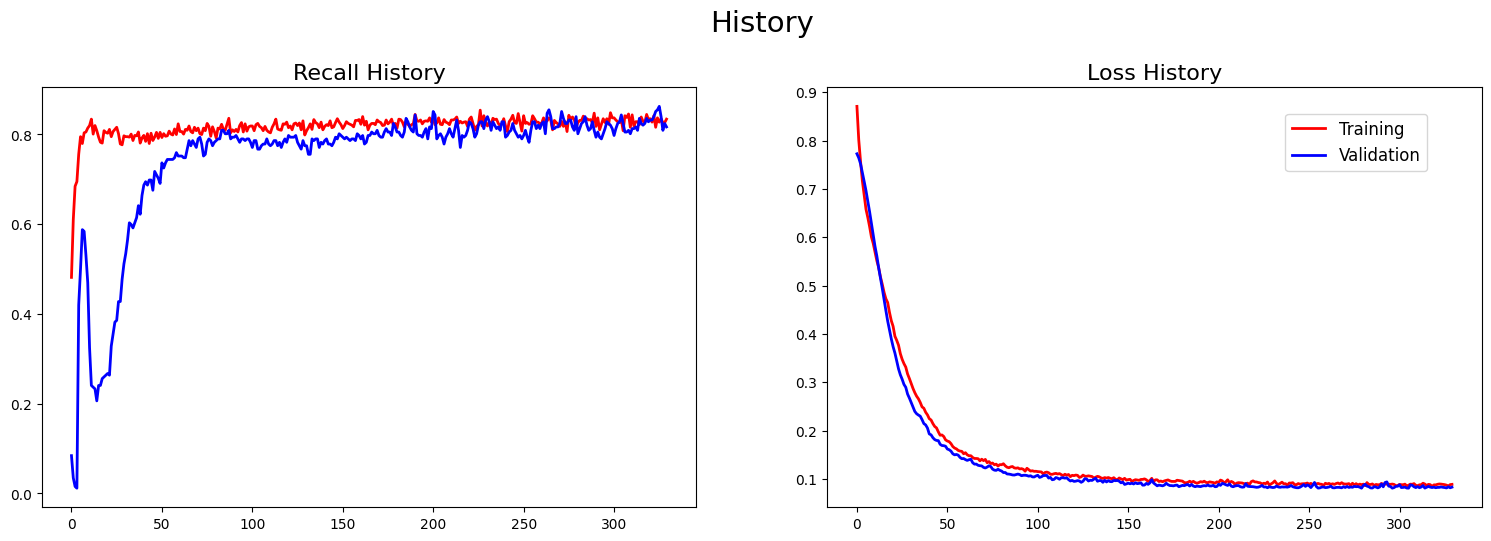

In [20]:
fig = plt.figure(figsize=(16, 6))
fig.suptitle('History', fontsize = 21)

# Recall Plot
ax = plt.subplot(1, 2, 1)
plt.title(f'Recall History', fontsize = 16, y = 1)
plt.plot(history.history["recall"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_recall"], color='b', linewidth=2, label="Validation")

# Loss Plot
ax = plt.subplot(1, 2, 2)
plt.title(f'Loss History', fontsize = 16, y = 1)
plt.plot(history.history["loss"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_loss"], color='b', linewidth=2, label="Validation")

plt.legend(fontsize=12, loc=(0.7, 0.8))
plt.subplots_adjust(right=0.95, left=0.05, top=0.85, bottom=0.15, wspace=0.2, hspace=0.2)
plt.show()

fig.savefig('model_history.png', dpi=80, bbox_inches='tight')

In [21]:
#AttributeError: 'Adam' object has no attribute 'build' 에러남
#import joblib
#
#model_file = 'model_file.joblib'
#
#joblib.dump(model, model_file)